# Frequency correlation plots for natural populations

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [4]:
data_root = "../results/builds/natural/natural_sample_1_with_10_vpm/"

In [5]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [6]:
tips.head(1)

,strain,timepoint,frequency
0,A/England/121/1995,1995-10-01,0.003272


In [7]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [8]:
tips_to_clades.head(1)

,tip,clade_membership,depth,timepoint
0,A/Jitie/1/1995,318c503,0,1995-10-01


In [9]:
forecasts = pd.read_csv(
    "%s/natural_sample_1_with_10_vpm_lbi_forecast.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "fitness", "frequency", "projected_frequency"]
)

In [10]:
forecasts.head(1)

,timepoint,strain,frequency,fitness,projected_frequency
0,1995-10-01,A/England/121/1995,0.003272,-2.645588,0.000436


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [11]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    how="left",
    left_on=["timepoint", "tip"],
    right_on=["timepoint", "strain"]
).drop(columns=["depth", "strain"])

In [12]:
clade_tip_initial_frequencies = clade_tip_initial_frequencies.fillna(0.0).copy()

In [13]:
clade_tip_initial_frequencies.head()

,tip,clade_membership,timepoint,frequency
0,A/Jitie/1/1995,318c503,1995-10-01,0.000164
1,A/Jitie/1/1995,8e08f7f,1995-10-01,0.000164
2,A/Jitie/1/1995,root,1995-10-01,0.000164
3,A/NewYork/654/1994,3ce6939,1995-10-01,0.000000
4,A/NewYork/654/1994,509b83b,1995-10-01,0.000000


In [14]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()

In [15]:
initial_clade_frequencies.head()

,timepoint,clade_membership,frequency
0,1995-10-01,02e323e,0.154225
1,1995-10-01,0451ac2,0.038982
2,1995-10-01,0734650,0.003272
3,1995-10-01,0acf798,0.044474
4,1995-10-01,1a74f77,0.188457


In [16]:
initial_clades = initial_clade_frequencies.query("frequency > 0.15 & timepoint >= '2002-10-01' & timepoint < '2015-04-01'").copy()

In [17]:
initial_clades.head()

,timepoint,clade_membership,frequency
2877,2002-10-01,02e323e,1.000002
2881,2002-10-01,048f8ca,1.000002
2883,2002-10-01,05a6dc1,0.517050
2891,2002-10-01,09e68a2,1.000002
2960,2002-10-01,35491c6,1.000002


In [18]:
initial_clades.tail()

,timepoint,clade_membership,frequency
33722,2014-10-01,f2ec31a,0.999987
33724,2014-10-01,f321e53,0.999987
33725,2014-10-01,f3f16af,0.999987
33800,2014-10-01,fd5608c,0.999987
33817,2014-10-01,root,0.999987


In [19]:
initial_clades.shape

(984, 3)

In [48]:
initial_clades[initial_clades["clade_membership"] == "c139e7c"]

,timepoint,clade_membership,frequency,final_timepoint
21969,2011-10-01,c139e7c,0.266878,2012-10-01
23680,2012-04-01,c139e7c,0.425949,2013-04-01
25478,2012-10-01,c139e7c,0.215038,2013-10-01
27325,2013-04-01,c139e7c,0.915614,2014-04-01
29246,2013-10-01,c139e7c,0.985170,2014-10-01


## Find future frequencies of large clades

In [20]:
initial_clades["final_timepoint"] = initial_clades["timepoint"] + pd.DateOffset(months=12)

In [21]:
initial_and_observed_clade_frequencies = initial_clades.merge(
    clade_tip_initial_frequencies,
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [22]:
initial_and_observed_clade_frequencies.shape

(912, 4)

In [23]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2002-10-01,02e323e,1.000002,1.000005
1,2002-10-01,048f8ca,1.000002,1.000005
2,2002-10-01,05a6dc1,0.517050,0.134300
3,2002-10-01,09e68a2,1.000002,1.000005
4,2002-10-01,35491c6,1.000002,1.000005


In [49]:
initial_and_observed_clade_frequencies.query("clade_membership == 'c139e7c'")

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
613,2011-10-01,c139e7c,0.266878,0.215038,0.805754
656,2012-04-01,c139e7c,0.425949,0.915614,2.149586
695,2012-10-01,c139e7c,0.215038,0.985170,4.581376
746,2013-04-01,c139e7c,0.915614,0.002964,0.003237
795,2013-10-01,c139e7c,0.985170,0.000000,0.000000


In [24]:
initial_and_observed_clade_frequencies["observed_growth_rate"] = (
    initial_and_observed_clade_frequencies["frequency_final"] / initial_and_observed_clade_frequencies["frequency"]
)

In [25]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2002-10-01,02e323e,1.000002,1.000005,1.000003
1,2002-10-01,048f8ca,1.000002,1.000005,1.000003
2,2002-10-01,05a6dc1,0.517050,0.134300,0.259743
3,2002-10-01,09e68a2,1.000002,1.000005,1.000003
4,2002-10-01,35491c6,1.000002,1.000005,1.000003


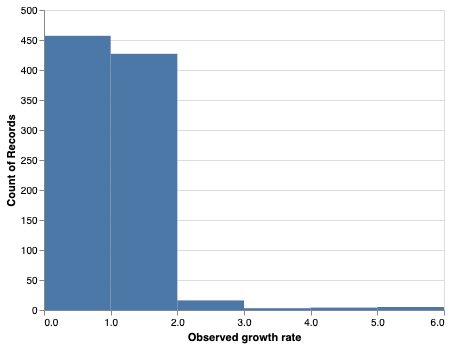

In [26]:
alt.Chart(initial_and_observed_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the LBI model as an example, first.

In [27]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    how="left",
    left_on=["timepoint", "tip"],
    right_on=["timepoint", "strain"]
).drop(columns=["depth", "strain", "fitness"])

In [28]:
clade_tip_estimated_frequencies = clade_tip_estimated_frequencies.fillna(0.0).copy()

In [29]:
clade_tip_estimated_frequencies.head()

,tip,clade_membership,timepoint,frequency,projected_frequency
0,A/Jitie/1/1995,318c503,1995-10-01,0.000164,0.000022
1,A/Jitie/1/1995,8e08f7f,1995-10-01,0.000164,0.000022
2,A/Jitie/1/1995,root,1995-10-01,0.000164,0.000022
3,A/NewYork/654/1994,3ce6939,1995-10-01,0.000000,0.000000
4,A/NewYork/654/1994,509b83b,1995-10-01,0.000000,0.000000


In [30]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum", "frequency": "sum"}).reset_index()

In [31]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency,frequency
0,1995-10-01,02e323e,0.038369,0.154225
1,1995-10-01,0451ac2,0.101271,0.038982
2,1995-10-01,0734650,0.000436,0.003272
3,1995-10-01,0acf798,0.047649,0.044474
4,1995-10-01,1a74f77,0.049959,0.188457


In [32]:
complete_clade_frequencies = initial_and_observed_clade_frequencies.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [33]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [34]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [35]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,frequency_other,estimated_growth_rate,year
0,2002-10-01,02e323e,1.000002,1.000005,1.000003,1.000000,1.000002,0.999998,2002
1,2002-10-01,048f8ca,1.000002,1.000005,1.000003,1.000000,1.000002,0.999998,2002
2,2002-10-01,05a6dc1,0.517050,0.134300,0.259743,0.414129,0.517050,0.800945,2002
3,2002-10-01,09e68a2,1.000002,1.000005,1.000003,1.000000,1.000002,0.999998,2002
4,2002-10-01,35491c6,1.000002,1.000005,1.000003,1.000000,1.000002,0.999998,2002


In [36]:
complete_clade_frequencies.shape

(912, 9)

In [37]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [38]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [39]:
mcc

0.49067418821884196

In [40]:
confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])

0.68760907504363

In [41]:
confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])

0.8200589970501475

In [42]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

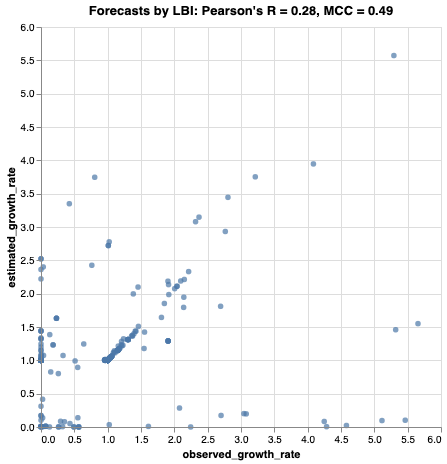

In [45]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

chart.save("forecast_growth_correlation_natural_lbi.svg")
chart

In [44]:
complete_clade_frequencies.shape

(912, 9)